In [ ]:
!pip3 install numpy opencv-python matplotlib scikit-learn pandas requests kagglehub

In [3]:
import zipfile
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

In [4]:
# Read face image from zip file
faces = dict()
with zipfile.ZipFile("../assets/40_people_faces.zip") as facezip:
    for filename in facezip.namelist():
        if not filename.endswith(".pgm"):
            continue # not a face picture
        with facezip.open(filename) as image:
            # we use OpenCV to decode the byte string into an array of pixels
            faces[filename] = cv2.imdecode(np.frombuffer(image.read(), np.uint8), cv2.IMREAD_GRAYSCALE)

File naming ex1: s1/1.pgm
File naming ex2: s1/10.pgm
File naming ex3: s1/2.pgm


Showing sample faces


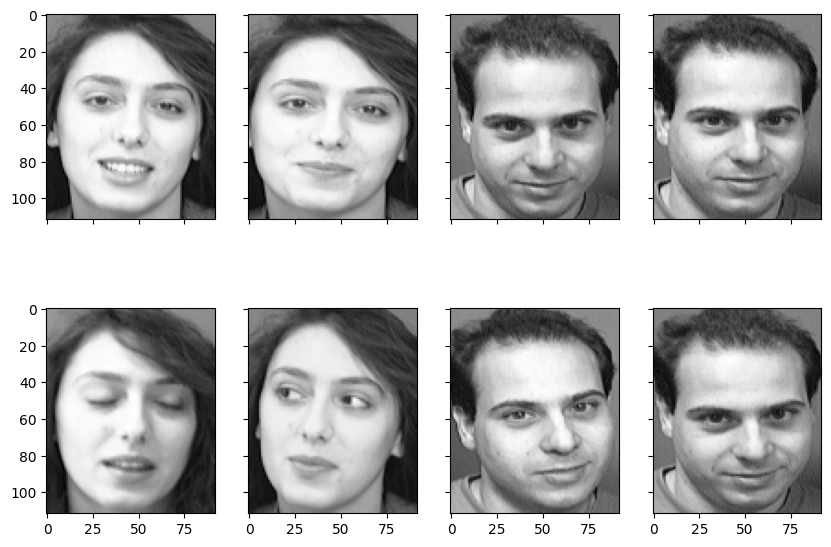

Face image shape: (112, 92)


In [5]:
# Show sample faces using matplotlib
img_number = 8
offset = 6

# showing the structure of the files
print("File naming ex1:", list(faces.keys())[0])
print("File naming ex2:", list(faces.keys())[1])
print("File naming ex3:", list(faces.keys())[2])
print('\n')

fig, axes = plt.subplots(2,4,sharex=True,sharey=True,figsize=(10,7))
# take last N of images
face_images = list(faces.values())[-img_number-offset:-offset]

for i in range(img_number):
    axes[i%2][i//2].imshow(face_images[i], cmap="gray")
print("Showing sample faces")
plt.show()

# Print the pixel size of each picture
face_shape = list(faces.values())[0].shape
print("Face image shape:", face_shape)

In [6]:
# Separate images of 1-39 person and  eigenfaces, keep entire class 40 and
# image 10 of class 39 as out-of-sample test
face_matrix = list()
person_face_label = list()
for key, val in faces.items():
    if key.startswith("s1/"):
        continue # this is our test set
    if key == "s28/10.pgm":
        continue # this is our test set
    face_matrix.append(val.flatten()) # save the images
    person_face_label.append(key.split("/")[0]) # save only the person number

# Create a NxM matrix with N images and M pixels per image
face_matrix = np.array(face_matrix)

Showing the eigenfaces


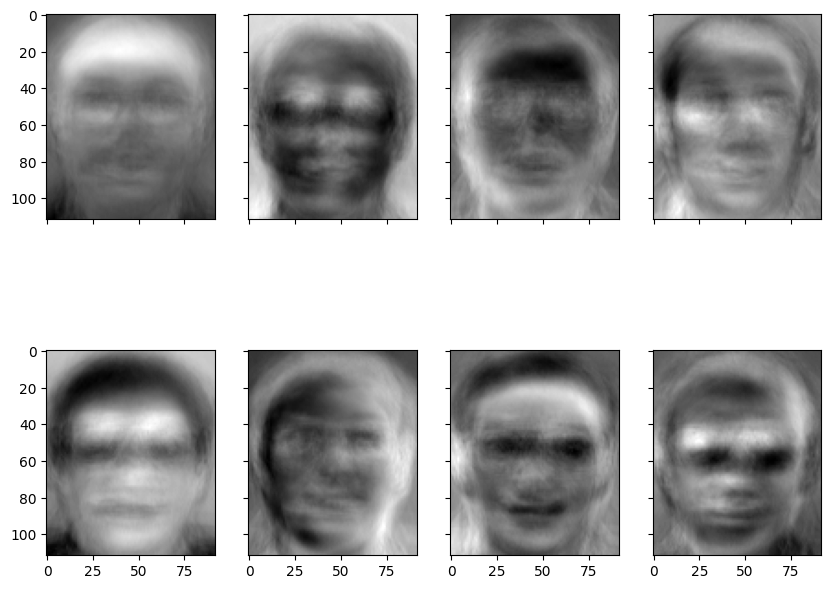

In [12]:
# Apply PCA, where each row represent an eigenvector/eigenface
# taking the first 50 eigenvectors (PC) with the highest eigenvalues
num_pc = 50
pca = PCA(n_components=num_pc).fit(face_matrix)

eigenfaces = pca.components_

# Show the first 8 eigenfaces/eigenvectors
fig, axes = plt.subplots(2,4,sharex=True,sharey=True,figsize=(10,8))
for i in range(img_number):
    axes[i%(img_number//4)][i//(img_number//4)].imshow(
      eigenfaces[i].reshape(face_shape),
      cmap="gray")

print("Showing the eigenfaces")
plt.show()

In [8]:
# printing the variance matrix (eigenvalues of each eigenvectors/principal component)
print(pca.explained_variance_ratio_)

[0.17078074 0.13251768 0.06973639 0.05307045 0.05069334 0.0339108
 0.0248833  0.02375155 0.0200623  0.01782981 0.01475419 0.01427501
 0.01116614 0.01076428 0.00997889 0.00930647 0.00874503 0.00843829
 0.00730196 0.0070581  0.00656922 0.00634575 0.0059916  0.00548796
 0.00542653 0.005066   0.00487506 0.00465253 0.00454182 0.00444664
 0.00442082 0.00408571 0.00398489 0.00377463 0.00362214 0.00353001
 0.0034703  0.00334717 0.00324199 0.00302977 0.00298107 0.00291314
 0.00283584 0.00267578 0.00265275 0.00260888 0.00250857 0.002486
 0.00244964 0.00230309]


In [9]:
# calculate the weight vector for each input picture and save it in
# 'weights' as a KxN matrix, where K is the number of eigenfaces and N
# the number of samples
weights = eigenfaces @ (face_matrix - pca.mean_).T
print("Shape of the weight matrix:", weights.shape)

Shape of the weight matrix: (50, 389)


Best match s28 with Euclidean distance 1899.517208


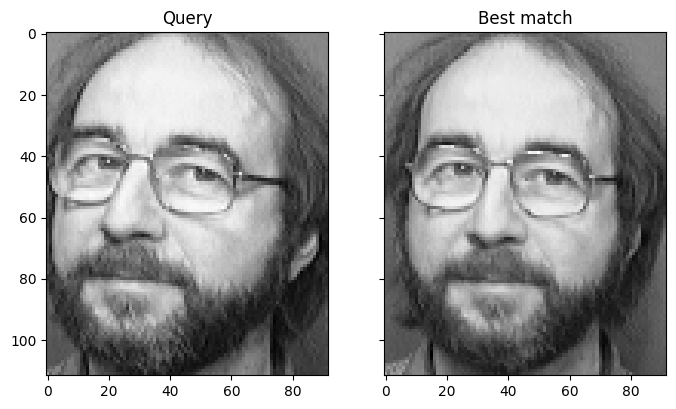

In [10]:
# Test on out-of-sample image of existing class
query = faces["s28/10.pgm"].reshape(1,-1)
query_weight = eigenfaces @ (query - pca.mean_).T
euclidean_distance = np.linalg.norm(weights - query_weight, axis=0)
best_match = np.argmin(euclidean_distance)
print("Best match %s with Euclidean distance %f" % (person_face_label[best_match], euclidean_distance[best_match]))
# Visualize
fig, axes = plt.subplots(1,2,sharex=True,sharey=True,figsize=(8,6))
axes[0].imshow(query.reshape(face_shape), cmap="gray")
axes[0].set_title("Query")
axes[1].imshow(face_matrix[best_match].reshape(face_shape), cmap="gray")
axes[1].set_title("Best match")
plt.show()

Best match s13 with Euclidean distance 3623.696406


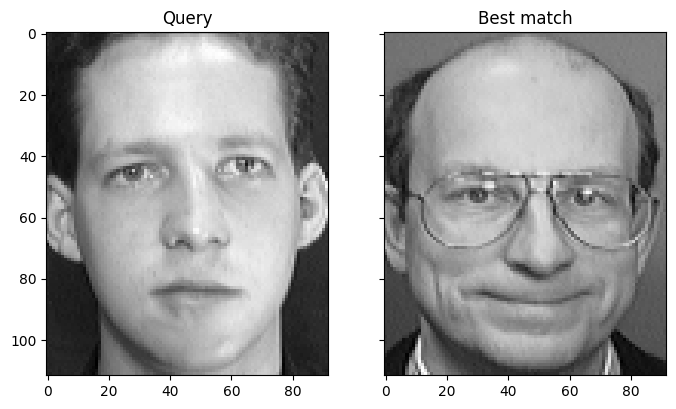

In [11]:
# Test on out-of-sample image of new class
query = faces["s1/8.pgm"].reshape(1,-1)
query_weight = eigenfaces @ (query - pca.mean_).T
euclidean_distance = np.linalg.norm(weights - query_weight, axis=0)
best_match = np.argmin(euclidean_distance)
print("Best match %s with Euclidean distance %f" % (person_face_label[best_match], euclidean_distance[best_match]))
# Visualize
fig, axes = plt.subplots(1,2,sharex=True,sharey=True,figsize=(8,6))
axes[0].imshow(query.reshape(face_shape), cmap="gray")
axes[0].set_title("Query")
axes[1].imshow(face_matrix[best_match].reshape(face_shape), cmap="gray")
axes[1].set_title("Best match")
plt.show()